In [ ]:
# reference to dataset:
# https://www.kaggle.com/mczielinski/bitcoin-historical-data

# mainstream libraries
import numpy as np
import pandas as pd
import math
import plotly.graph_objects as go

# i need code and data from my drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# import code for ESN, DeepESN, GruESN from drive
import sys
sys.path.append('/content/drive/Othercomputers/Il mio MacBook Air/SimpleESN')
#from Simple_ESN import ESN

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ISPR/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
data = data.dropna(how='any')
data = data[-5000:]
data.index = pd.RangeIndex(len(data.index))
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1616847600,54023.15,54143.65,54001.00,54073.79,1.206344,65235.920747,54077.371044
1,1616847660,54062.40,54132.44,54040.20,54111.30,5.066663,273889.740820,54057.220967
2,1616847720,54111.19,54140.01,54085.23,54128.42,0.772219,41780.641367,54104.684258
3,1616847780,54122.97,54150.68,54114.29,54150.68,0.364972,19757.220612,54133.585060
4,1616847840,54150.83,54150.83,54075.94,54075.94,2.153112,116481.811720,54099.283043
...,...,...,...,...,...,...,...,...
4995,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4996,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4997,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4998,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [ ]:
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

fig.show()

In [ ]:
r = 1

# separate input data from output data: output data is shifted to the left by r positions,
# so that it goes ahead by r temporal steps. 
dataset_x = data[['Open','High','Low','Close']].to_numpy().T

print( np.mean(dataset_x), np.var(dataset_x) )
dataset_x = dataset_x  - np.mean(dataset_x)
dataset_x = dataset_x / np.sqrt(np.var(dataset_x))
print( np.mean(dataset_x), np.var(dataset_x) )

dataset_y = np.roll(dataset_x,-r,axis=1)

# discard rolled positions because they are not meaningfull anymore
dataset_x = dataset_x[:,r:np.size(dataset_x,axis=1)-r]
dataset_y = dataset_y[:,r:np.size(dataset_y,axis=1)-r];

assert all([all(dataset_x[:,i+r]-dataset_y[:,i] == np.array([0., 0., 0., 0.]))for i in range(np.size(dataset_x,axis=1)-r ) ] )

# reshape data so that each data point is a column vector
dataset_x = dataset_x.T.reshape(-1,4,1)
dataset_y = dataset_y.T.reshape(-1,4,1)

# separate training data from validation and test.
train_x = dataset_x[:1000]
train_y = dataset_y[:1000]

test_x = dataset_x[1000:]
test_y = dataset_y[1000:]

print(np.shape(train_x), np.shape(train_y), np.shape(test_x), np.shape(test_y))

56820.1531865 1814521.999689251
2.1600499167107046e-16 1.0
(1000, 4, 1) (1000, 4, 1) (3998, 4, 1) (3998, 4, 1)


In [ ]:
import numpy as np
from scipy.stats import uniform
import scipy.sparse as s


class ESN():
  # VETTORI STATO E INPUT COLONNA
  def __init__(self, rho =0.9, Nr=100, Nu=1, r_density =0.2, i_density =0.1, Ny=1, scale_in = 0.7):
    #iperparametri rete
    self.rho = rho
    self.Nr = Nr
    self.Nu = Nu
    self.Ny = Ny
    self.r_density = r_density
    self.i_density = i_density
    self.scale_in = scale_in

    #parametri rete
    self.W = self.build_recurrent_matrix()
    self.W_in = self.build_input_matrix(scale_in)

    self.x = np.zeros((Nr,1)) # stato corrente

  def build_recurrent_matrix(self):
    wrandom = s.random(self.Nr,self.Nr,density = self.r_density, data_rvs=uniform(loc=-1,scale=2).rvs ).todense() # matrice sparsa con valori in distribuzione uniforme tra -1 e 1
    w = wrandom * ( self.rho / max(np.abs(np.linalg.eigvals(wrandom))) )
    return np.array(w)

  def build_input_matrix(self, scale_in):
    w_in = s.random( self.Nr , self.Nu+1 , density = self.i_density , data_rvs=uniform(loc=-1,scale=2).rvs ).todense() # matrice sparsa con valori in distribuzione uniforme tra -1 e 1
    w_in = w_in * scale_in # normalizzazione
    return np.array(w_in)

  def compute_state(self, u):
    u = np.vstack( (u.reshape(-1,1),1) )
    z = np.dot( self.W_in, u ) + np.dot( self.W, self.x )
    output = np.tanh( z )
    self.x = output
    return np.copy( output ) # lo restituisco se serve a qualcuno da fuori

  def compute_output(self):
    return np.dot( self.Wout, np.vstack((self.x,1)) )

  def compute_output(self,u):
    return np.dot( self.Wout, np.vstack((self.compute_state(u),1)) )

  def train(self,train_x,train_y,wash_seq):
    for d in wash_seq:
      self.compute_state(d) # washout

    # collect states
    c_state = self.compute_state
    s = np.array( list( map( c_state, train_x ) ) ) # shape(len(data),Nr,1)
    s = np.hstack( [ np.vstack((t,1)) for t in s] )
    assert np.shape(s) == (self.Nr+1, np.size(train_x,axis=0)), f'{np.shape(s)}'

    # collect outputs
    d = np.hstack( [t for t in train_y] )
    assert np.shape(d) == (self.Ny,np.size(train_y,axis=0))

    self.Wout = np.dot( d, np.linalg.pinv(s) )
    #self.Wout = np.transpose( np.dot( np.linalg.pinv(s) , d.T ) )

  def score(self, X, y, washout=True):
    c_out = self.compute_output
    out = np.array( list( map( c_out, X ) ) ) #shape (len(data),Ny,1)
    out = out.reshape(-1,self.Ny,1) # solo output monodimensionale
    wash_len = min(int(len(X)/3),500)
    return np.mean( np.square( y[wash_len:] - out[wash_len:] ) ), out 


In [ ]:

n = ESN(Nu=4, Ny=4,rho =0.9, Nr=100, r_density =0.1, i_density =1, scale_in = 1 )
n.train(train_x[101:],train_y[101:],train_x[:100])
err , out = n.score(test_x,test_y)
print()
print( np.hstack( ( out[10] ,train_y[10] ) ) )



[[-0.45374188 -1.91358792]
 [-0.44317279 -1.91303114]
 [-0.47141424 -1.93605938]
 [-0.45773965 -1.93605938]]


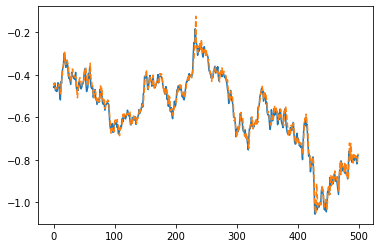

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.plot(test_y[:500,1,:],'-')

plt.plot(out[:500,1,:],'--')

In [ ]:
d = {'Open' : test_y[:500,0,:].reshape(-1),
     'High' : test_y[:500,1,:].reshape(-1),
     'Low' : test_y[:500,2,:].reshape(-1),
     'Close' : test_y[:500,3,:].reshape(-1)
     }
real = pd.DataFrame(data = d, index = pd.RangeIndex(500) )

d = {'Open' : out[:500,0,:].reshape(-1),
     'High' : out[:500,1,:].reshape(-1),
     'Low' : out[:500,2,:].reshape(-1),
     'Close' : out[:500,3,:].reshape(-1)
     }
predicted = pd.DataFrame(data = d, index = pd.RangeIndex(500) )
predicted

,Open,High,Low,Close
0,-0.430462,-0.436704,-0.444720,-0.446301
1,-0.460140,-0.448286,-0.485012,-0.461531
2,-0.458062,-0.440318,-0.471638,-0.455628
3,-0.473389,-0.466849,-0.490317,-0.479163
4,-0.469574,-0.465833,-0.489906,-0.478504
...,...,...,...,...
495,-0.801325,-0.779760,-0.818687,-0.792488
496,-0.804459,-0.784144,-0.820121,-0.802062
497,-0.817711,-0.796197,-0.832488,-0.809189
498,-0.824173,-0.808747,-0.839763,-0.820846


In [ ]:
fig = go.Figure(data=[go.Candlestick(x=real.index,
                open=real['Open'],
                high=real['High'],
                low=real['Low'],
                close=real['Close'])])

fig.add_trace(
    go.Scatter(
        x=predicted.index,
        y=predicted['Low'],
        mode="lines",
        line=go.scatter.Line(color="orange"),
        showlegend=False)
)
fig.show()